## Import Libraries and Data

In [4]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_2606-0207-2023.csv', firstRow=624, lastRow=630)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_100723_S625-630.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [5]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=54s and ended at t=490s; mass=44.292249999999996g
This equals a volume of 44.381m; expected was 44.893mL; error is 1.141%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0015 g/s and for 2nd derivative = 0.0004999999999999998 g/s^2


<IPython.core.display.Javascript object>


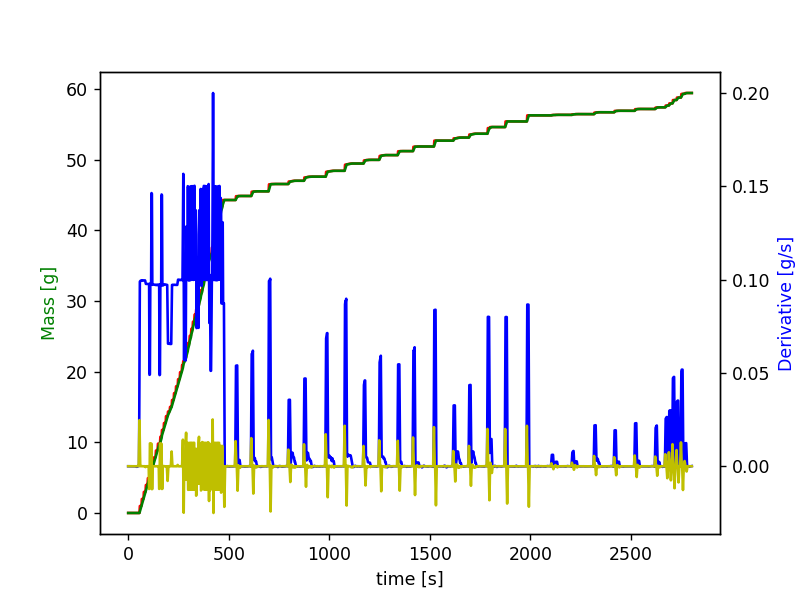

Addition of 0.573g Plantapon ACG 50 detected from 530s to 560s - expected volume = 0.55mL and actual volume = 0.512mL (resulting error is 6.964%)
Addition of 0.661g Plantapon ACG 50 detected from 608s to 642s - expected volume = 0.55mL and actual volume = 0.59mL (resulting error is 7.386%)
Addition of 1.041g Plantapon ACG 50 detected from 694s to 724s - expected volume = 0.925mL and actual volume = 0.928mL (resulting error is 0.415%)
Addition of 0.465g Plantapon LC 7 detected from 792s to 836s - expected volume = 0.558mL and actual volume = 0.438mL (resulting error is 21.634%)
Addition of 0.585g Plantapon LC 7 detected from 870s to 914s - expected volume = 0.558mL and actual volume = 0.551mL (resulting error is 1.398%)
Addition of 0.834g Plantacare 818 detected from 978s to 1028s - expected volume = 0.942mL and actual volume = 0.766mL (resulting error is 18.673%)
Addition of 1.03g Plantacare 818 detected from 1072s to 1118s - expected volume = 0.945mL and actual volume = 0.954mL (resul

In [6]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.001875 g/s and for 2nd derivative = 0.0008593749999999999 g/s^2


<IPython.core.display.Javascript object>


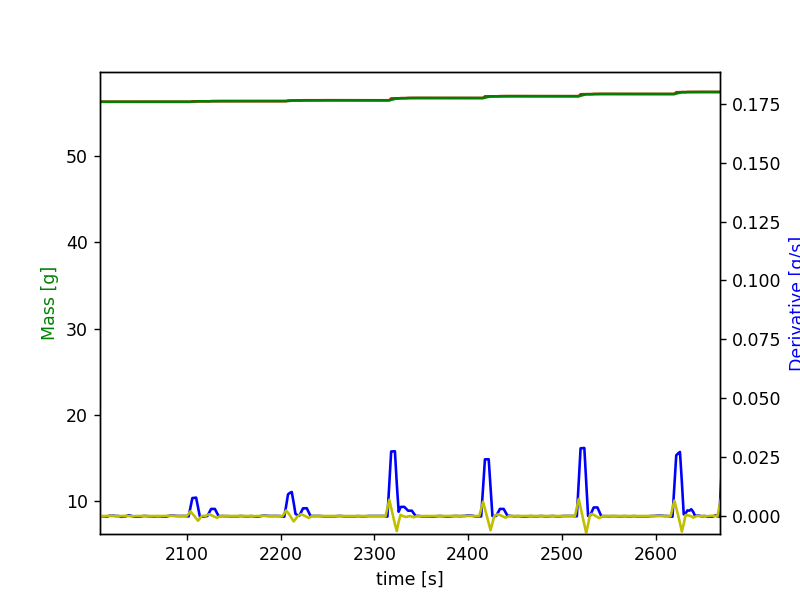

Addition of 0.083g Salcare Super 7 detected from 2100s to 2134s - expected volume = 0.096mL and actual volume = 0.074mL (resulting error is 22.547%)
Addition of 0.106g Salcare Super 7 detected from 2202s to 2232s - expected volume = 0.094mL and actual volume = 0.097mL (resulting error is 2.913%)
Addition of 0.267g Salcare Super 7 detected from 2312s to 2344s - expected volume = 0.271mL and actual volume = 0.242mL (resulting error is 10.619%)
Addition of 0.216g Salcare Super 7 detected from 2412s to 2442s - expected volume = 0.172mL and actual volume = 0.194mL (resulting error is 13.024%)
Addition of 0.259g Salcare Super 7 detected from 2514s to 2544s - expected volume = 0.227mL and actual volume = 0.234mL (resulting error is 3.137%)
Addition of 0.234g Salcare Super 7 detected from 2616s to 2642s - expected volume = 0.181mL and actual volume = 0.214mL (resulting error is 18.371%)


In [8]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=8, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


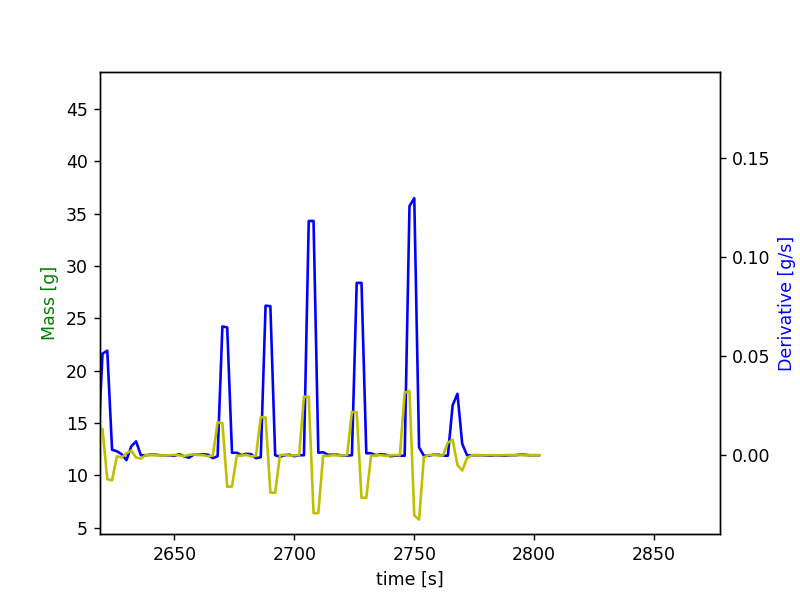

Addition of 0.26g Arlypon F detected from 2666s to 2678s - expected volume = 0.294mL and actual volume = 0.295mL (resulting error is 0.192%)
Addition of 0.296g Arlypon F detected from 2684s to 2696s - expected volume = 0.322mL and actual volume = 0.342mL (resulting error is 6.093%)
Addition of 0.478g Arlypon F detected from 2702s to 2714s - expected volume = 0.519mL and actual volume = 0.547mL (resulting error is 5.286%)
Addition of 0.351g Arlypon F detected from 2722s to 2734s - expected volume = 0.373mL and actual volume = 0.398mL (resulting error is 6.687%)
Addition of 0.517g Arlypon F detected from 2744s to 2758s - expected volume = 0.566mL and actual volume = 0.591mL (resulting error is 4.444%)
Addition of 0.124g Arlypon F detected from 2762s to 2776s - expected volume = 0.122mL and actual volume = 0.142mL (resulting error is 16.509%)


In [9]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2600,2616,2636,2656,2676,2884,2906])

## Consolidate results and create output

In [10]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_100723_S625-S630.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_26216\2866299346.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
624,625.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.389687,0.000000,8.014029,0.0,0.000000,0.0,0.0,0.0,0.0,0.830203,2.609568,0.0
625,626.0,0.0,12.097237,0.000000,0.000000,11.746451,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.038642,2.900358,0.0
626,627.0,0.0,0.000000,0.000000,8.532348,0.000000,0.000000,0.000000,10.087127,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2.735449,4.892589,0.0
627,628.0,0.0,0.000000,10.538243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,8.684042,0.0,0.0,0.0,0.0,2.165994,3.521778,0.0
628,629.0,0.0,0.000000,0.000000,0.000000,0.000000,12.237726,0.000000,9.437568,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2.581520,5.155561,0.0
629,630.0,0.0,10.136977,0.000000,10.024052,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2.281623,1.202263,0.0
